# TFG de Miguel Ángel

En este documento vamos a ir haciendo un pequeño análisis del TFG convenientemente documentado, que servirá en el futuro para poder realizar la memoria y el análisis completo.

## Datos

A continuación un sucinto resumen de cómo es la estructura de los datos

### ECGs

Los ECGs son de una única derivación (un canal), con una duración entre **9 segs a 60 segs**. 

* Una reflexión, para el esquema de clasificación sin utilizar las redes neuronales recurrentes, podríamos hacer que todas las series tuviesen la misma longitud, por ejemplo 60 seg, de tal forma que las más cortas se podrían generar replicando de alguna forma la serie para que tuviese 60 seg.

* La **frecuencia de muestreo** es de 300 Hz

* Los tipos de posibles señales son:
    1. Normal
    2. AF
    3. Otros ritmos
    4. Ruidoso


### Training

La base de datos de training tiene la información de la clasificación del ritmo en los csv que están en la carpeta training. **Es necesario leer la cabecera, pero no continene la información de la clasificación**



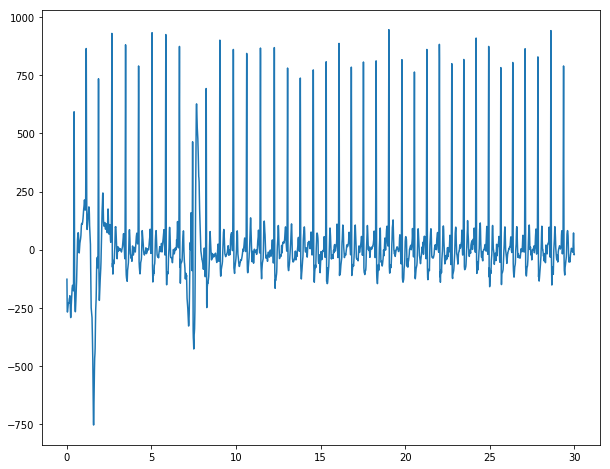

In [2]:
#Vamos a leer un par de ejemplo, así como la cabecera
%matplotlib inline
import numpy as np

import matplotlib.pyplot as plt
from tfg_tools import read_challenge_mat_files, processing_ecg, plot_all_records

ecg, header = read_challenge_mat_files('A00001.mat','./')
fs = float(header['fs'])
t = np.arange(0,len(ecg))/fs 
plt.figure(figsize = (10,8))
plt.plot(t,ecg)



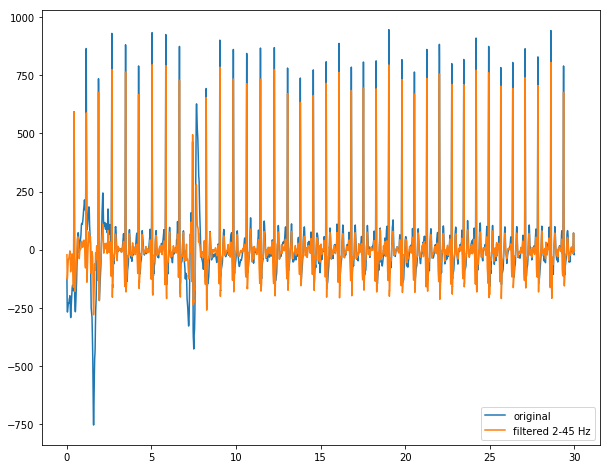

In [3]:
ecg_filtered = processing_ecg(ecg)

plt.figure(figsize = (10,8))
plt.plot(t,ecg,label='original')
plt.plot(t,ecg_filtered,label='filtered 2-45 Hz')
plt.legend()

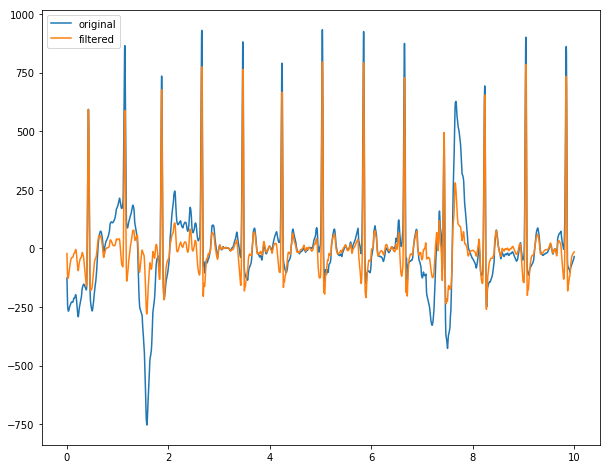

In [4]:
#zoom

plt.figure(figsize = (10,8))
plt.plot(t[t<10],ecg[t<10],label='original')
plt.plot(t[t<10],ecg_filtered[t<10],label='filtered')
plt.legend()

# Chapter Preprocesamiento y análisis exploratorio de señales

**TO DO**

* Crear una rutina que te pinte todas las señales. Un for que vaya pintando todas las señales y que se en la figura pinte información de los ejes (segundos y mv) y en la leyenda indique cómo ha sido clasificada la señal. Convendría pintar la señal original y la filtrada entre 2 y 45 Hz. Que no pase a la siguiente iteración del bucle hasta que, por ejemplo, se pulse un click de raton o alguna tecla.

* Sacar la siguiente información:
    * Número de sujetos en cada clase (esto lo puedes sacar del fichero en el que viene la clasificación de cada señal)
    * Longitudes de las señales: Una función que se cree un vector con todas las longitudes de todas las señales, y que pinte un histograma de las longitudes.
   
* Con esto podemos divisar los modeos de deep learning para clasificación

## Chapter : Modelos de redes neuronales

Vamos a comenzar utilizando una red neuronal ..

$$y(t) = \frac{1}{x}$$